In [3]:
import numpy as np
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import cPickle, gzip
f = gzip.open('/home/will/Desktop/data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [5]:
Xtrain = np.r_[train_set[0],valid_set[0]]
Ytrain = np.r_[train_set[1],valid_set[1]]
Xtest = test_set[0]
Ytest = test_set[1]

In [6]:
del train_set, valid_set, test_set

In [7]:
def xavier_init(inputShape, outputShape): 
    low = -np.sqrt(6.0/(inputShape + outputShape)) 
    return tf.random_uniform((inputShape, outputShape), 
                             minval=low, maxval=-low, 
                             dtype=tf.float32)

def lrelu(x, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * tf.abs(x)
    
class MLP(object):
    
    def __init__(self,Shapes,actFuns):
        self.Shapes = Shapes
        self.actFuns = actFuns
        self.W = [tf.Variable(xavier_init(Shapes[i],Shapes[i+1])) 
                                  for i in range(len(Shapes)-1)]
        self.b = [tf.Variable(tf.zeros([Shapes[i]])) for i in range(1,len(Shapes))]
        self.para = self.W + self.b
        
    def predict(self,X):
        for w,b,fun in zip(self.W, self.b, self.actFuns):
            X = fun(tf.matmul(X,w)+b)
        return X

class multilayerConv(object):
    
    def __init__(self,Shapes,actFuns,Strides,Padding,forward=True,outputShapes=None):
        # Shapes is a list of shape of the form [filter_height, filter_width, in_channels, out_channels]
        self.forward = forward # conv or conv_transpose
        self.Shapes = Shapes
        self.actFuns = actFuns
        self.Strides = Strides
        self.Padding = Padding 
        self.outputShapes = outputShapes
        self.W = [tf.Variable(tf.random_normal(Shapes[i])/8) for i in range(len(Shapes))]
        _index = 3 if forward else 2
        self.b = [tf.Variable(tf.zeros([Shapes[i][_index]])) 
                              for i in range(len(Shapes))]
        self.para = self.W + self.b
        
    def predict(self,X):
        if self.forward: 
            for w,b,fun,stride,padding in zip(self.W, self.b, self.actFuns,self.Strides,self.Padding):
                X = fun(tf.nn.conv2d(X,w,stride,padding)+b)
        else:
            for w,b,output,fun,stride,padding in zip(self.W, self.b, self.outputShapes, self.actFuns,self.Strides,self.Padding):
                X = fun(tf.nn.conv2d_transpose(X,w,output,stride,padding)+b)            
        return X

In [8]:
class GAN(object):
    
    def __init__(self,GShapes,DShapes,zShape,batchSize,GActFun,DActFun,r):
        self.X = tf.placeholder(tf.float32,[batchSize,GShapes[-1]])
        self.Z = tf.placeholder(tf.float32,[batchSize,zShape])
        self.zShape = zShape
        self.r = r
        self.batchSize = batchSize
        
        # Generator
        self.G_MLP = MLP(GShapes,GActFun)
        self.X_fake = self.G_MLP.predict(self.Z)
        
        # Discriminator
        self.D_MLP = MLP(DShapes,DActFun)
        D_fake = self.D_MLP.predict(self.X_fake)
        D_real = self.D_MLP.predict(self.X)
        
        # loss
        self.G_loss = -tf.reduce_mean(tf.log(D_fake))
        self.D_loss = -tf.reduce_mean(tf.log(D_real)+tf.log(1-D_fake))
        #loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, 
        #                                                                   labels=tf.ones_like(D_real)*0.9))
        #loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake,
        #                                                                   labels=tf.zeros_like(D_fake)))
        #self.D_loss = loss_real + loss_fake
        #self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))


        # optimizer
        self.optimizer_G = tf.train.AdamOptimizer(learning_rate=self.r).minimize(self.G_loss,var_list=self.G_MLP.para)
        self.optimizer_D = tf.train.AdamOptimizer(learning_rate=self.r).minimize(self.D_loss,var_list=self.D_MLP.para)
        
        # session
        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _partial_fit(self,X_np):
        #_,_,loss_G,loss_D = self.sess.run([self.optimizer_G,self.optimizer_D,self.G_loss,self.D_loss],
        #                          {self.X:X_np, self.Z:np.random.randn(self.batchSize,self.zShape)})
        _,loss_G = self.sess.run([self.optimizer_G,self.G_loss],
                                          {self.Z:np.random.randn(self.batchSize,self.zShape)})
        _,loss_D = self.sess.run([self.optimizer_D,self.D_loss],
                                          {self.X:X_np, self.Z:np.random.randn(self.batchSize,self.zShape)})        
        return loss_G,loss_D
    
    def fit(self,X,iterations):
        N = X.shape[0]
        n = N/self.batchSize
        for i in range(iterations):
            index_ = np.random.permutation(N)
            cumLoss_G,cumLoss_D = 0,0
            for j in range(n):
                Loss_G,Loss_D = self._partial_fit(X[index_[j*self.batchSize:(j+1)*self.batchSize]])
                cumLoss_G += Loss_G
                cumLoss_D += Loss_D
            print "iter: {}, loss_G: {}, loss_D: {}".format(i,cumLoss_G/n, cumLoss_D/n)        
    
    def sample(self):
        return self.sess.run(self.X_fake,{self.Z:np.random.randn(self.batchSize,self.zShape)})

In [102]:
class CGAN(object):
    # Conditional GAN
    
    def __init__(self,GShapes,DShapes,zShape,batchSize,GActFun,DActFun,r,condSize):
        self.X = tf.placeholder(tf.float32,[batchSize,GShapes[-1]])
        self.Z = tf.placeholder(tf.float32,[batchSize,zShape])
        self.CondReal = tf.placeholder(tf.float32,[batchSize,condSize])
        self.CondFake = tf.placeholder(tf.float32,[batchSize,condSize])
        self.zShape = zShape
        self.r = r
        self.batchSize = batchSize
        
        # Generator
        self.G_MLP = MLP(GShapes,GActFun)
        self.X_fake = self.G_MLP.predict(tf.concat([self.Z,self.CondReal],1))
        
        # Discriminator
        self.D_MLP = MLP(DShapes,DActFun)
        D_fake = self.D_MLP.predict(tf.concat([self.X_fake,self.CondReal],1))
        D_real = self.D_MLP.predict(tf.concat([self.X,self.CondReal],1))
        D_mismatch = self.D_MLP.predict(tf.concat([self.X,self.CondFake],1))
        
        # loss
        self.G_loss = -tf.reduce_mean(tf.log(D_fake))
        self.D_loss = -tf.reduce_mean(tf.log(D_real)+0.5*tf.log(1-D_fake)+0.5*tf.log(1-D_mismatch))
        #loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, 
        #                                                                   labels=tf.ones_like(D_real)*0.9))
        #loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake,
        #                                                                   labels=tf.zeros_like(D_fake)))
        #self.D_loss = loss_real + loss_fake
        #self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))


        # optimizer
        self.optimizer_G = tf.train.AdamOptimizer(learning_rate=self.r).minimize(self.G_loss,var_list=self.G_MLP.para)
        self.optimizer_D = tf.train.AdamOptimizer(learning_rate=self.r).minimize(self.D_loss,var_list=self.D_MLP.para)
        
        # session
        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _partial_fit(self,X_np,condreal,condfake):
        _,_,loss_G,loss_D = self.sess.run([self.optimizer_G,self.optimizer_D,self.G_loss,self.D_loss],
                                  {self.X:X_np, self.Z:np.random.randn(self.batchSize,self.zShape),\
                                   self.CondReal:condreal,self.CondFake:condfake})
       
        return loss_G,loss_D
    
    def fit(self,X,Y,iterations,CondSampler):
        # CondSampler generate sample from P(cond) that does not equal to Y, with first dimention being batch size
        
        N = X.shape[0]
        n = N/self.batchSize
        for i in range(iterations):
            index_ = np.random.permutation(N)
            cumLoss_G,cumLoss_D = 0,0
            for j in range(n):
                Loss_G,Loss_D = self._partial_fit(X[index_[j*self.batchSize:(j+1)*self.batchSize]],\
                                                 Y[index_[j*self.batchSize:(j+1)*self.batchSize]],\
                                                 CondSampler(Y[index_[j*self.batchSize:(j+1)*self.batchSize]]))
                cumLoss_G += Loss_G
                cumLoss_D += Loss_D
            print "iter: {}, loss_G: {}, loss_D: {}".format(i,cumLoss_G/n, cumLoss_D/n)        
    
    def sample(self,cond):
        return self.sess.run(self.X_fake,{self.Z:np.random.randn(self.batchSize,self.zShape),\
                                         self.CondReal:cond})
    

In [50]:
gan = GAN([100,400,784],[784,400,1],100,100,[lrelu,tf.nn.sigmoid],[lrelu,tf.nn.sigmoid],1e-4)
#gan = GAN([100,400,784],[784,400,1],100,100,[tf.nn.relu,tf.nn.sigmoid],[tf.nn.relu,tf.nn.sigmoid],1e-3)
#gan = GAN([100,400,784],[784,400,1],100,100,[lrelu,tf.nn.sigmoid],[lrelu,tf.nn.sigmoid],1e-3)

In [51]:
gan.fit(Xtrain,20)

iter: 0, loss_G: 3.62880906244, loss_D: 0.185587011483
iter: 1, loss_G: 3.39735698342, loss_D: 0.110831621774
iter: 2, loss_G: 3.08105964859, loss_D: 0.149447181821
iter: 3, loss_G: 2.87965286771, loss_D: 0.203282685876
iter: 4, loss_G: 3.31118509809, loss_D: 0.154630374809
iter: 5, loss_G: 3.38984376828, loss_D: 0.146495853414
iter: 6, loss_G: 2.45236017048, loss_D: 0.375007635653
iter: 7, loss_G: 2.49275380095, loss_D: 0.325280999665
iter: 8, loss_G: 2.5892975982, loss_D: 0.342537562127
iter: 9, loss_G: 2.5003421547, loss_D: 0.352258734877
iter: 10, loss_G: 2.48295915047, loss_D: 0.352599811529
iter: 11, loss_G: 2.59890191833, loss_D: 0.287206918796
iter: 12, loss_G: 2.65016463359, loss_D: 0.296511832451
iter: 13, loss_G: 2.67333796382, loss_D: 0.364614891609
iter: 14, loss_G: 2.63552731951, loss_D: 0.393127128854
iter: 15, loss_G: 2.65120050192, loss_D: 0.402080558538
iter: 16, loss_G: 2.5204518199, loss_D: 0.404485061318
iter: 17, loss_G: 2.57731276333, loss_D: 0.382056840534
iter:

In [56]:
X_sample = gan.sample()

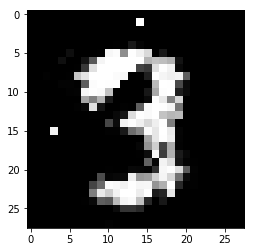

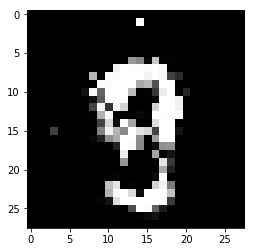

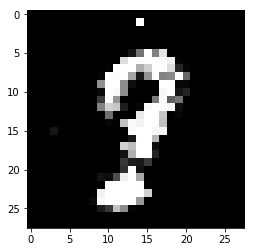

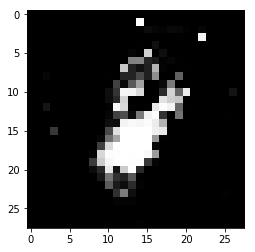

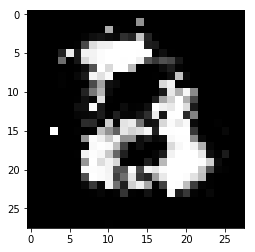

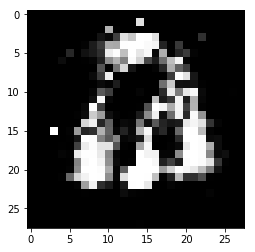

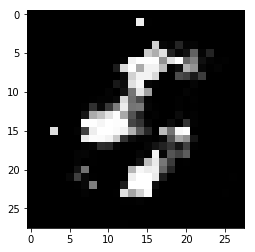

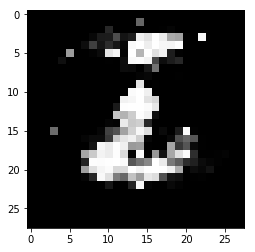

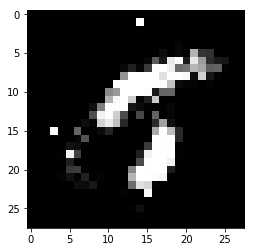

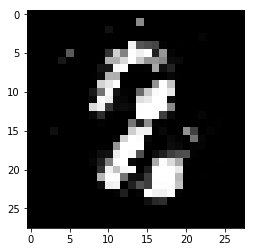

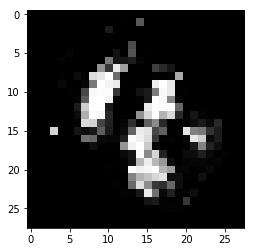

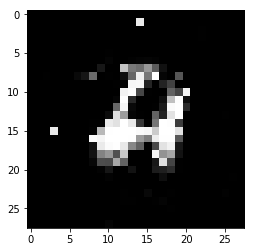

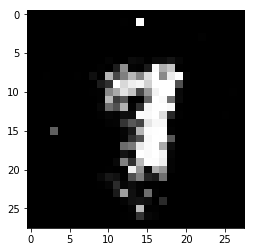

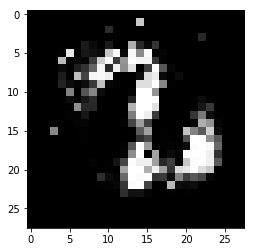

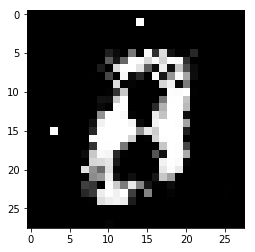

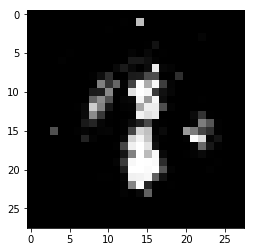

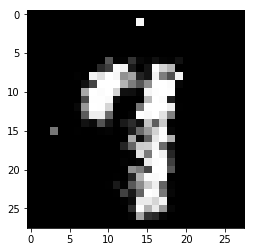

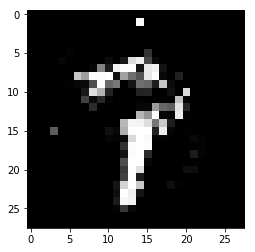

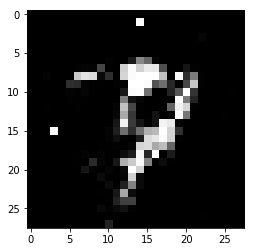

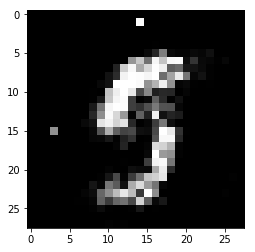

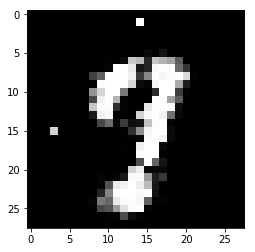

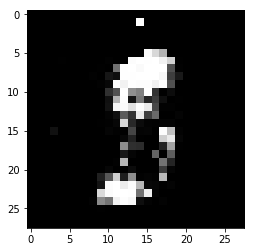

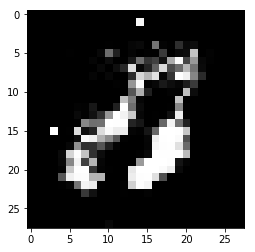

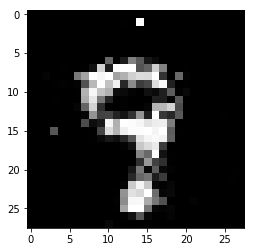

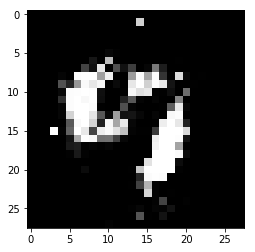

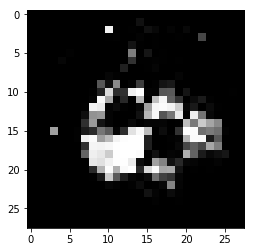

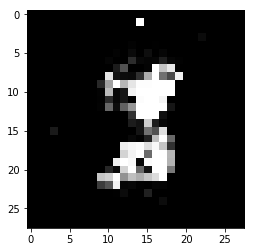

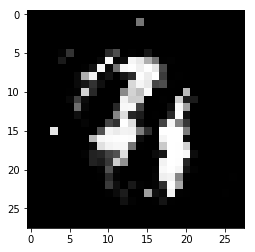

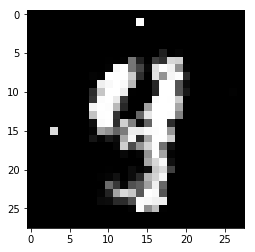

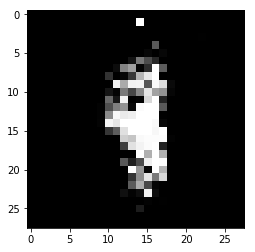

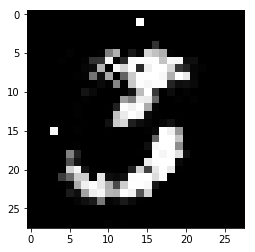

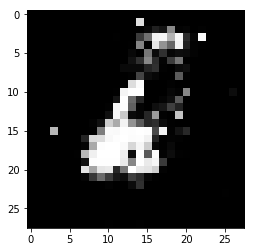

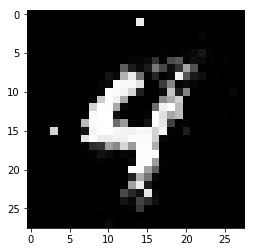

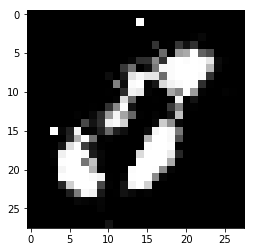

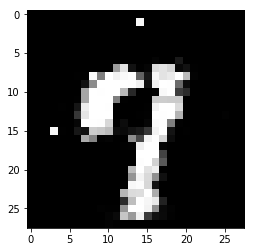

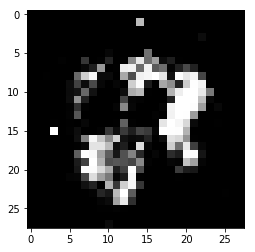

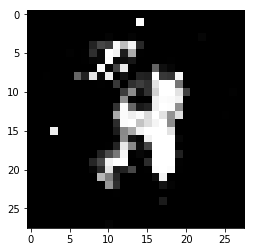

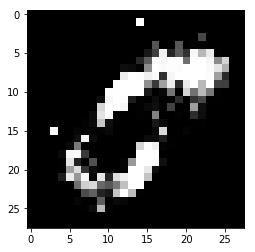

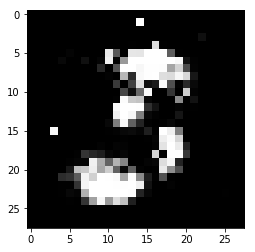

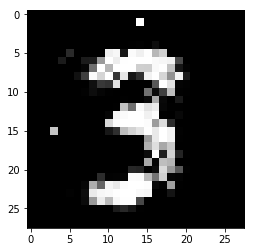

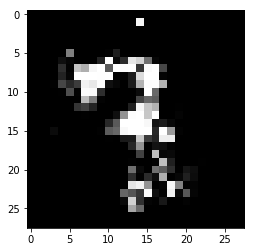

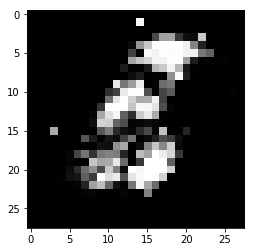

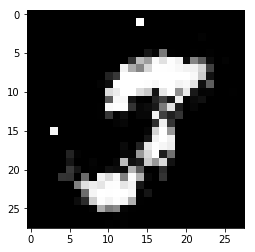

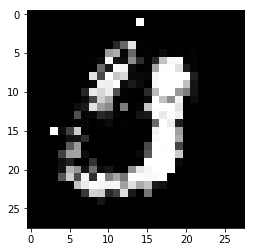

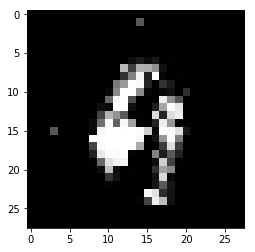

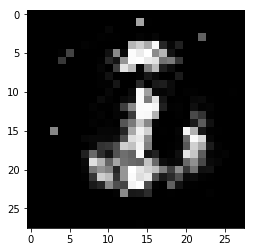

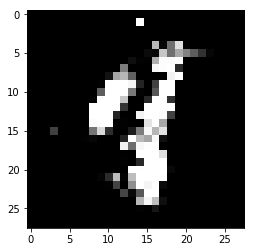

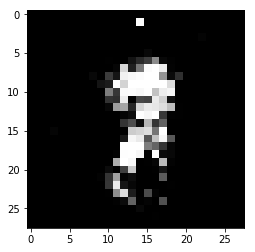

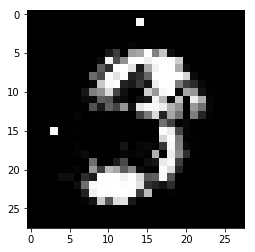

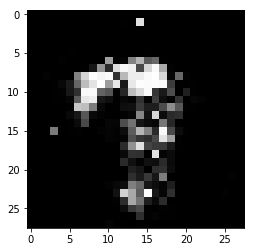

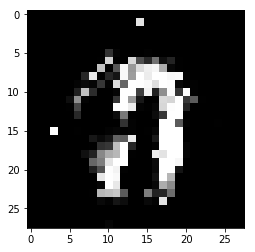

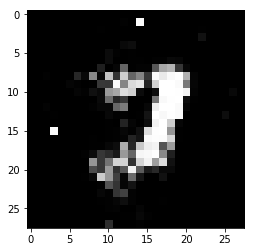

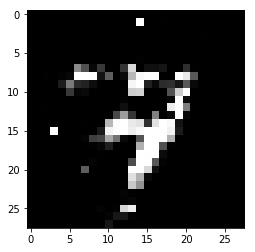

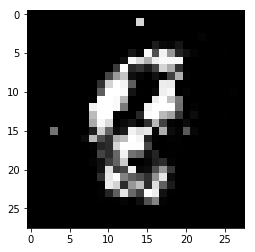

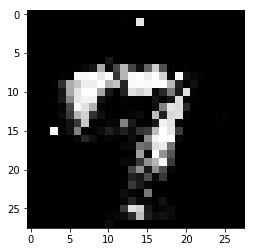

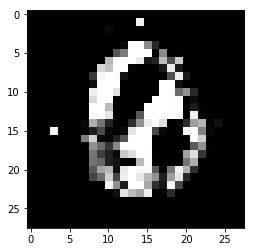

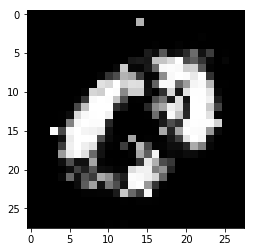

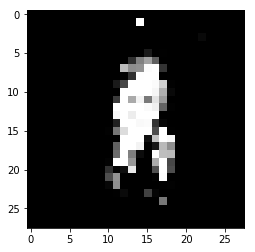

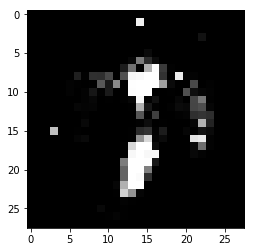

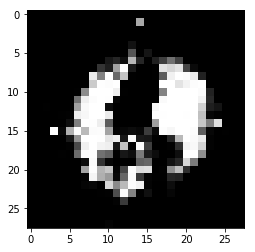

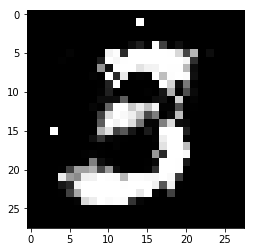

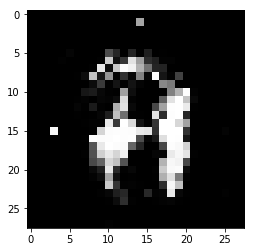

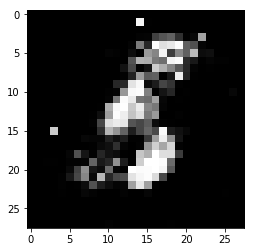

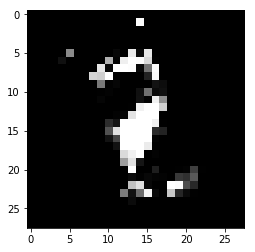

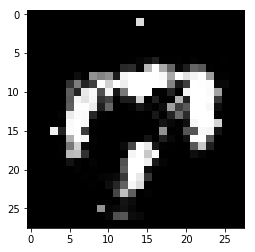

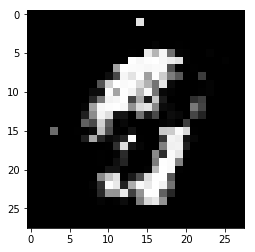

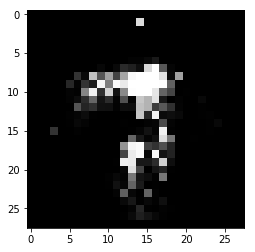

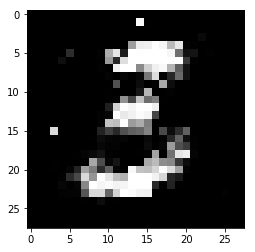

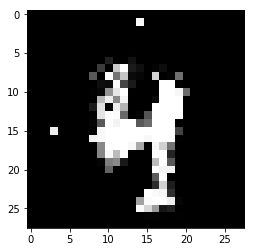

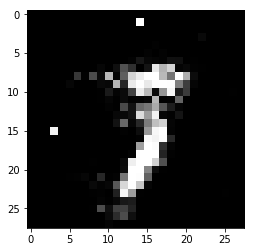

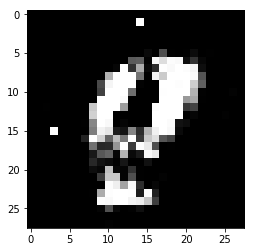

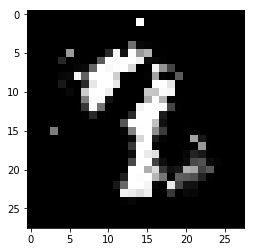

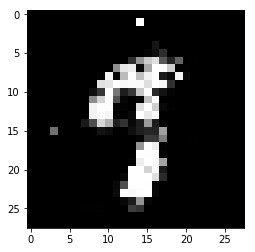

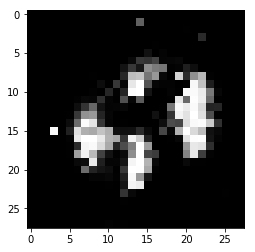

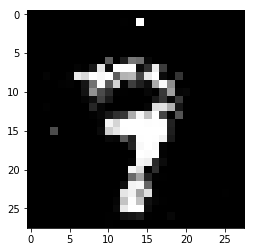

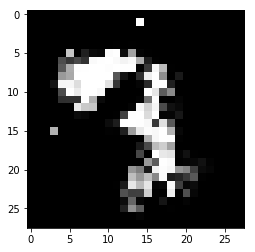

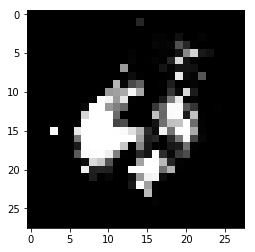

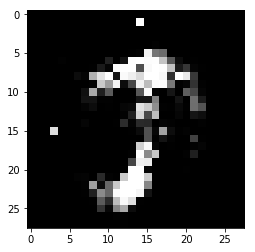

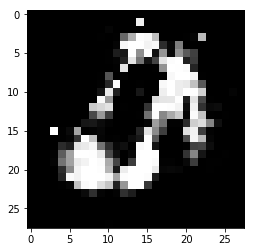

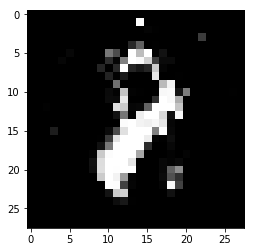

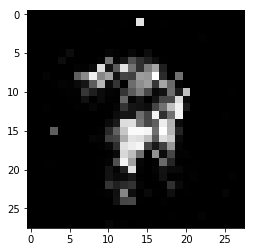

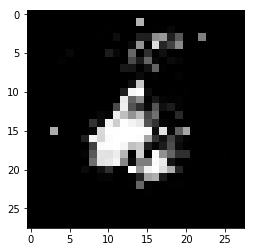

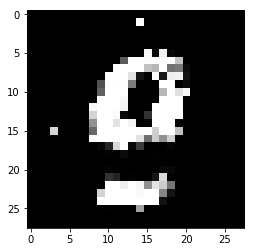

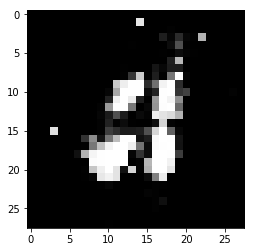

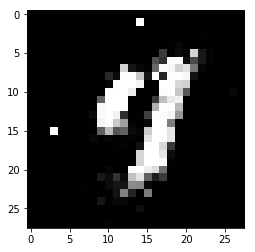

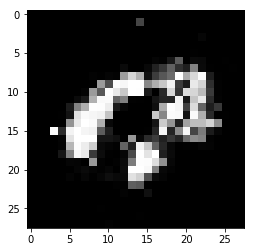

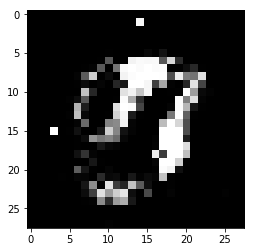

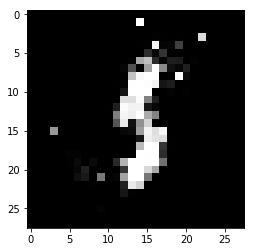

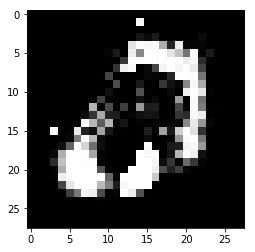

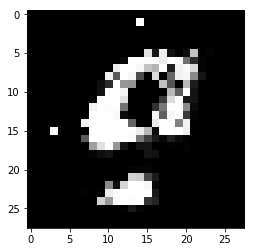

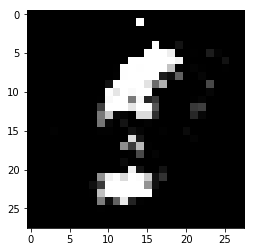

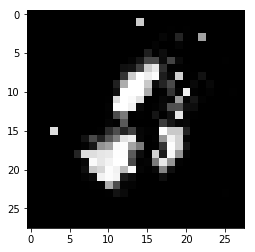

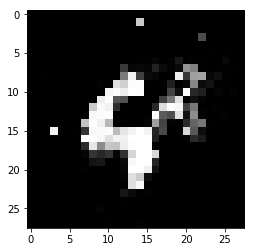

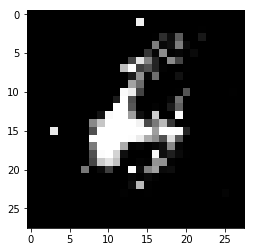

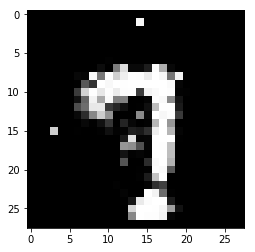

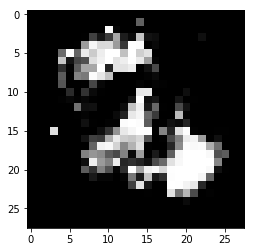

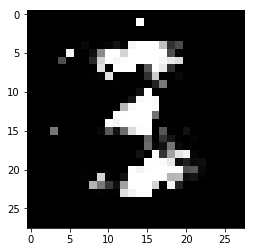

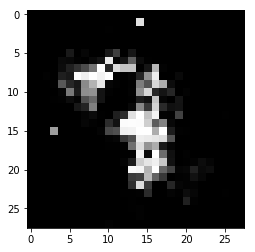

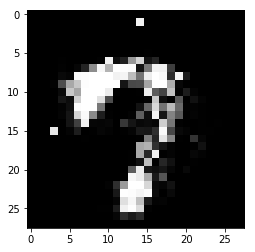

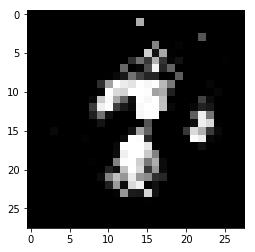

In [57]:
for s in X_sample:
    plt.imshow(np.reshape(s,(28,28)),cmap='gray')
    plt.show()

In [103]:
gan = CGAN([100+10,400,784],[784+10,400,1],100,100,[tf.nn.relu,tf.nn.sigmoid],[tf.nn.relu,tf.nn.sigmoid],1e-4,10)
#gan = GAN([100,400,784],[784,400,1],100,100,[tf.nn.relu,tf.nn.sigmoid],[tf.nn.relu,tf.nn.sigmoid],1e-3)
#gan = GAN([100,400,784],[784,400,1],100,100,[lrelu,tf.nn.sigmoid],[lrelu,tf.nn.sigmoid],1e-3)

In [97]:
n = Ytrain.shape[0]
Ytrain2 = np.zeros((n,10))
Ytrain2[range(n),Ytrain] = 1
# sampler = lambda size: np.random.multinomial(1,Ytrain2.sum(0)/n,size)

In [98]:
def CondSampler(Y):
    sample = np.zeros_like(Y)
    P = 1-Y
    P = P/(Y.shape[1]-1)
    for i in range(Y.shape[0]):
        sample[i]=np.random.multinomial(1,P[i],1)
    return sample

In [104]:
gan.fit(Xtrain,Ytrain2,30,CondSampler)

iter: 0, loss_G: 3.63482065539, loss_D: 0.931833026409
iter: 1, loss_G: 2.43594057202, loss_D: 0.773898723225
iter: 2, loss_G: 2.71281193614, loss_D: 0.541047347983
iter: 3, loss_G: 3.59259148439, loss_D: 0.390667958806
iter: 4, loss_G: 4.3557559816, loss_D: 0.296959790314
iter: 5, loss_G: 4.49959323486, loss_D: 0.248727390791
iter: 6, loss_G: 4.33863776207, loss_D: 0.228983295014
iter: 7, loss_G: 3.14732864261, loss_D: 0.253912340005
iter: 8, loss_G: 2.68304344495, loss_D: 0.283110454356
iter: 9, loss_G: 2.69663196564, loss_D: 0.271124867201
iter: 10, loss_G: 2.83938686252, loss_D: 0.260618934582
iter: 11, loss_G: 3.04260855516, loss_D: 0.249828562513
iter: 12, loss_G: 2.9149416256, loss_D: 0.262081187566
iter: 13, loss_G: 2.63893949231, loss_D: 0.285285990437
iter: 14, loss_G: 2.49562254707, loss_D: 0.294995171453
iter: 15, loss_G: 2.47446249048, loss_D: 0.288429518268
iter: 16, loss_G: 2.38250384649, loss_D: 0.297825313037
iter: 17, loss_G: 2.39351494471, loss_D: 0.305397576491
iter

Sample from condition = 0

In [105]:
temp = np.zeros((100,10))
temp[:,0] = 1
X_sample = gan.sample(temp)

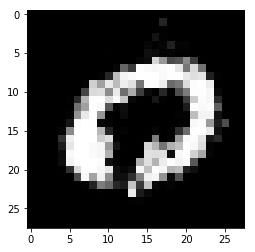

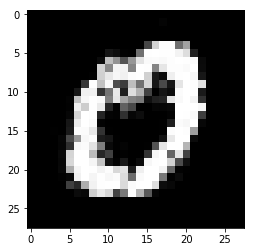

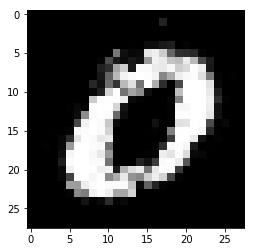

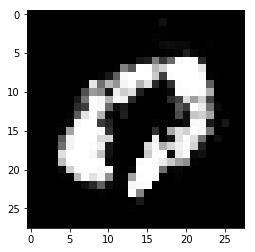

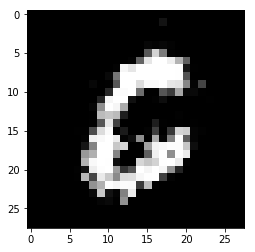

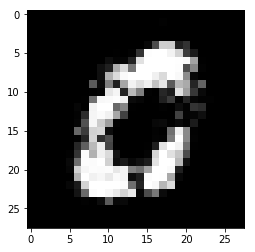

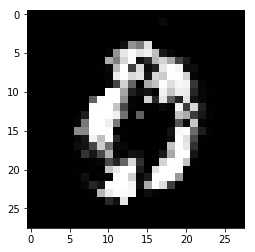

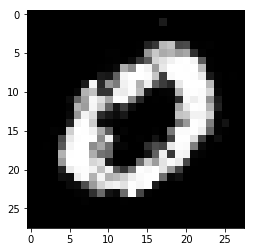

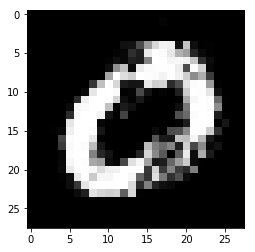

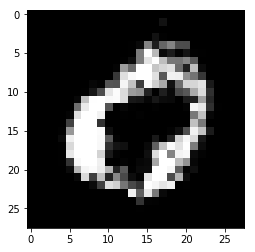

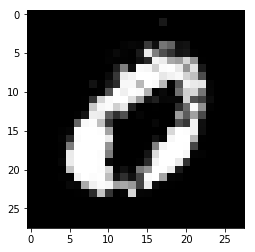

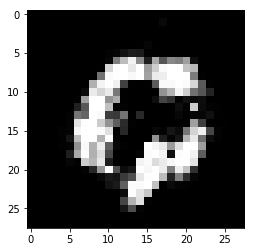

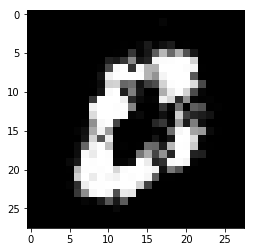

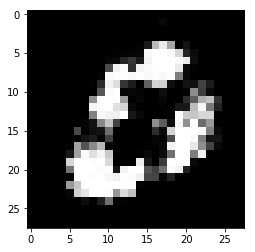

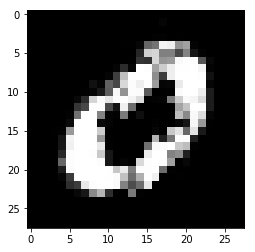

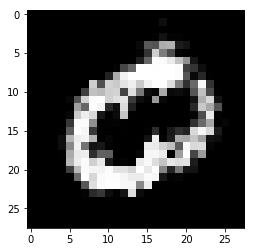

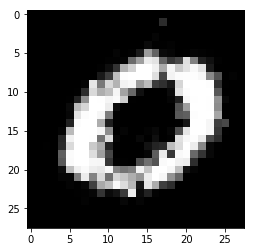

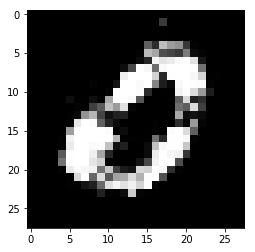

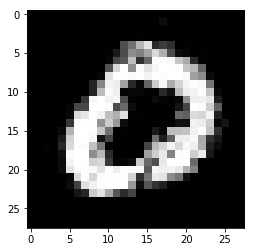

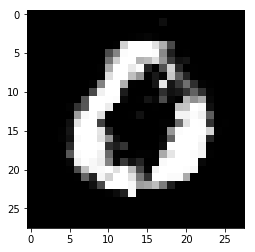

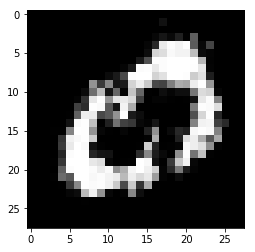

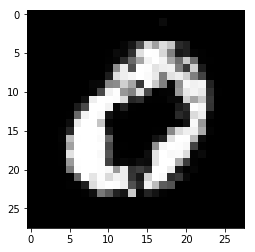

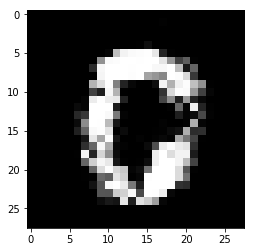

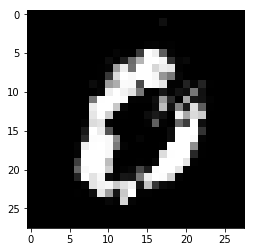

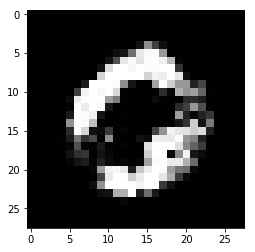

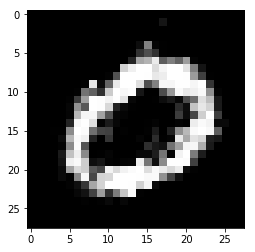

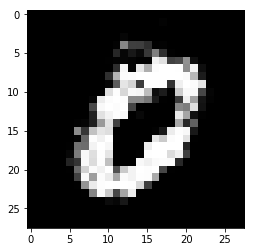

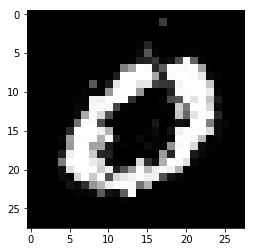

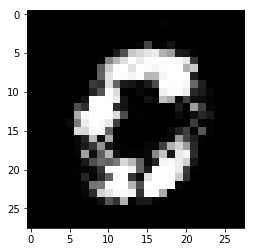

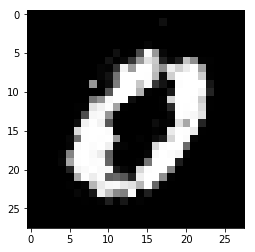

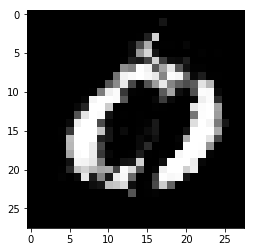

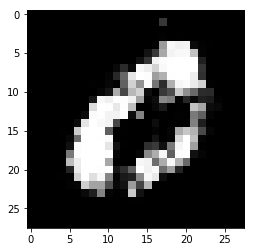

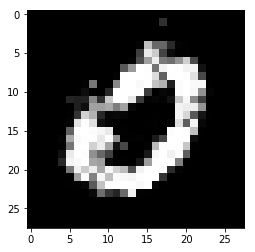

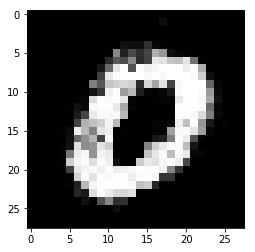

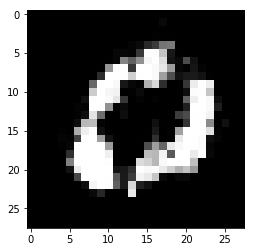

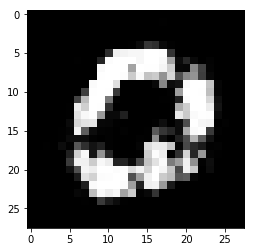

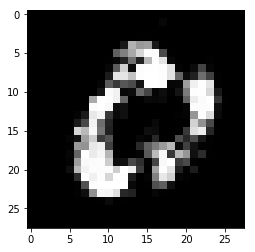

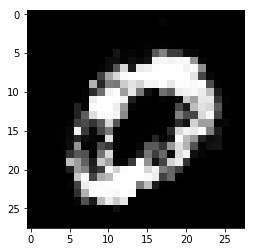

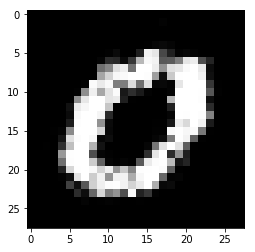

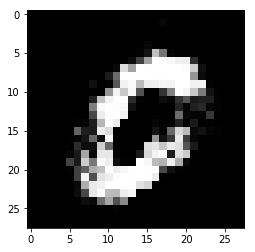

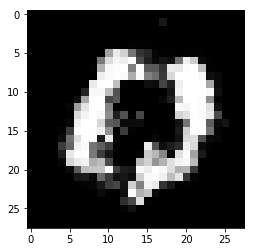

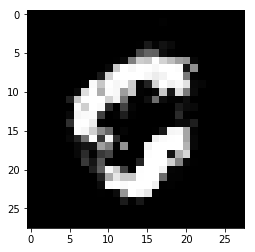

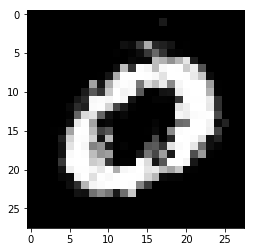

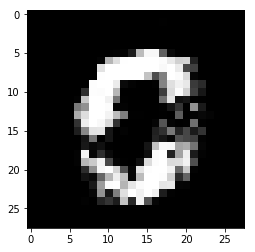

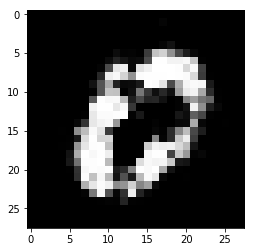

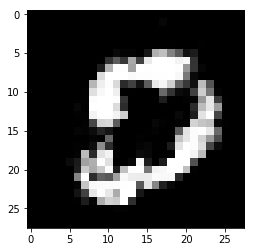

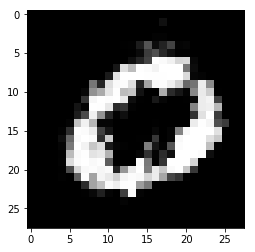

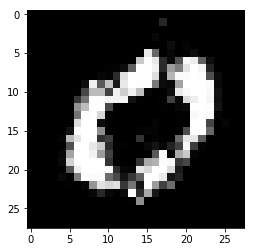

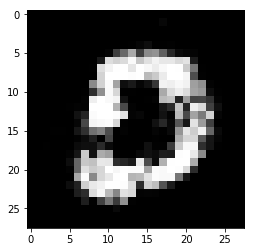

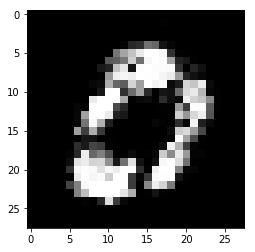

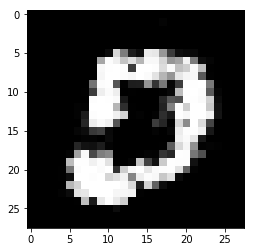

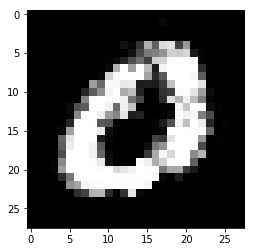

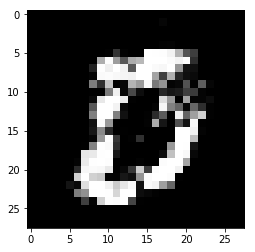

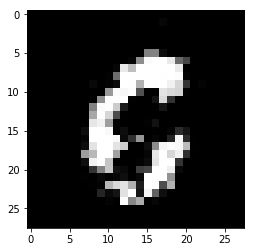

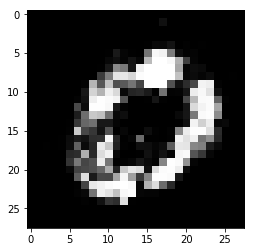

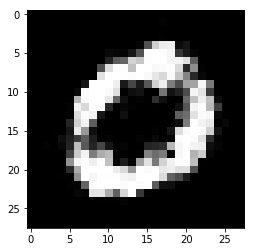

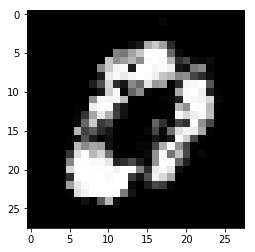

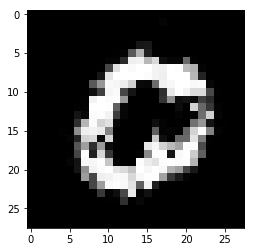

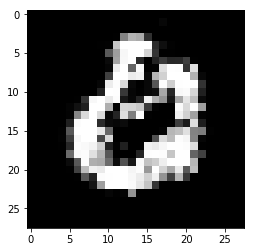

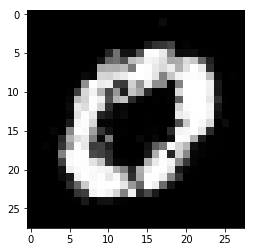

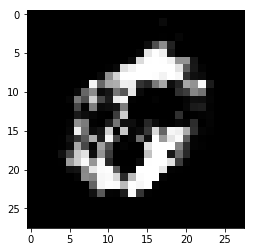

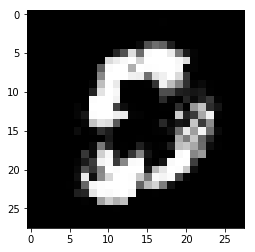

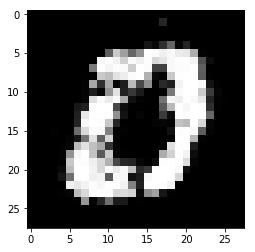

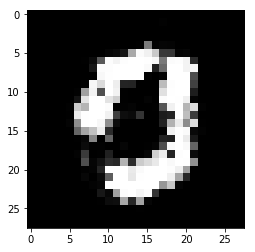

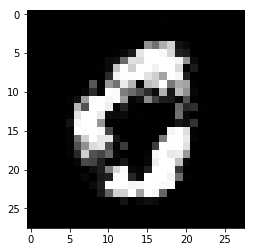

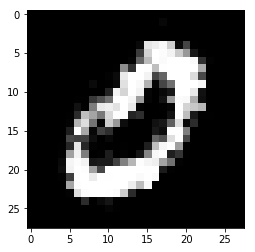

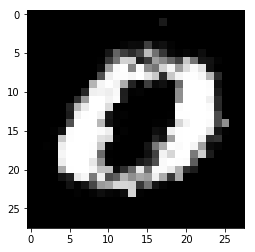

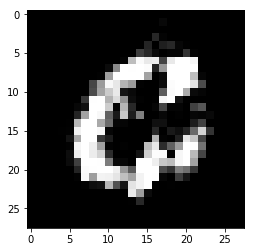

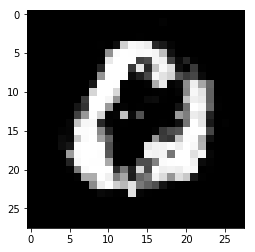

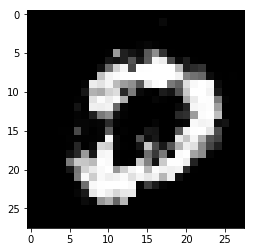

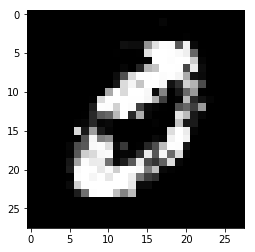

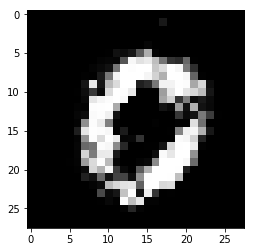

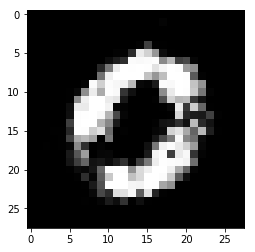

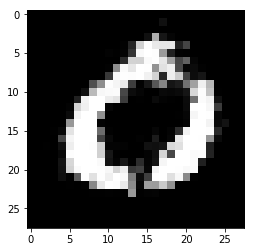

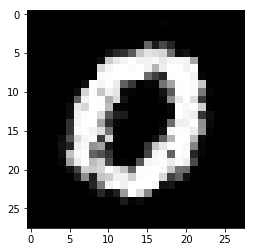

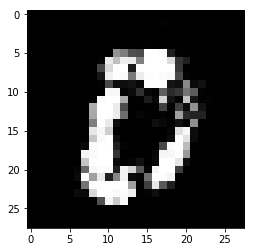

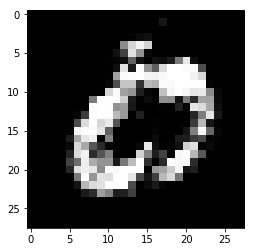

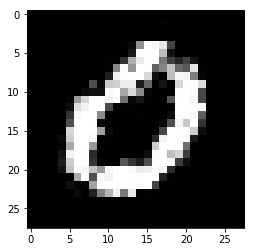

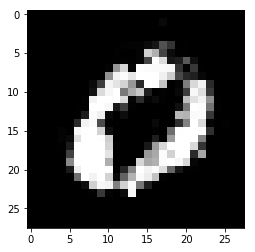

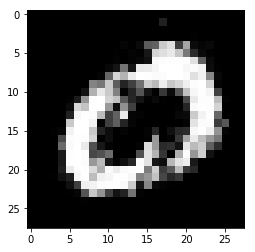

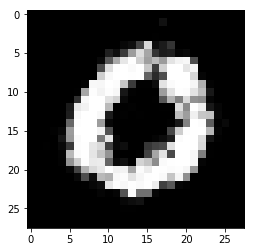

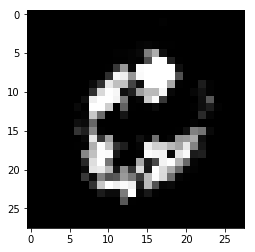

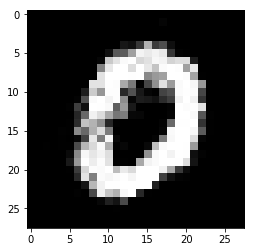

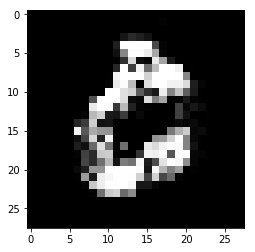

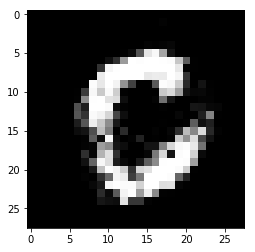

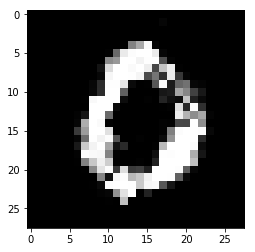

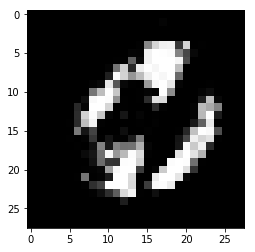

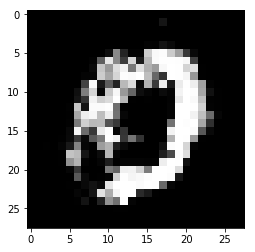

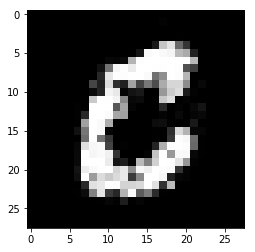

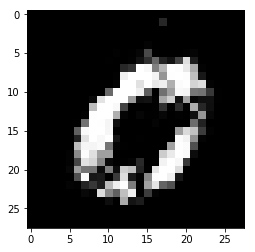

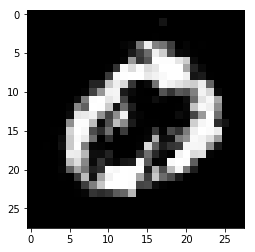

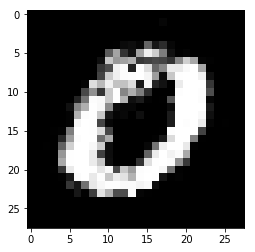

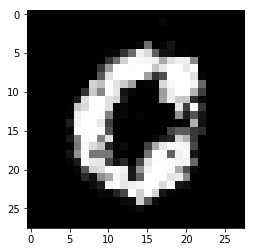

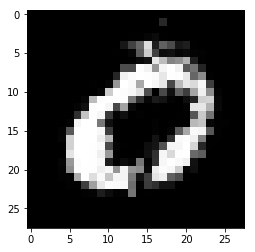

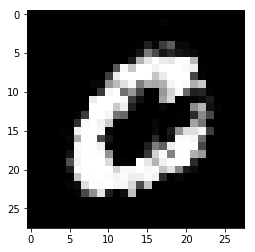

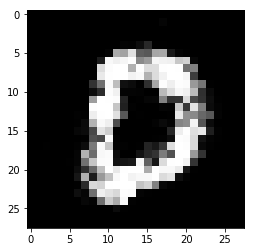

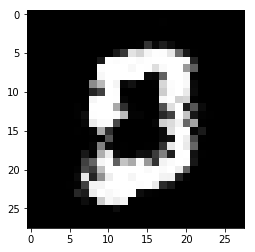

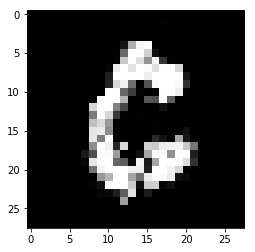

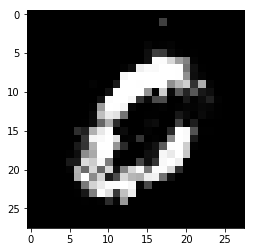

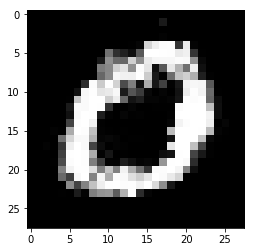

In [106]:
for s in X_sample:
    plt.imshow(np.reshape(s,(28,28)),cmap='gray')
    plt.show()

Sample from condition = 7

In [113]:
temp = np.zeros((100,10))
temp[:,7] = 1
X_sample = gan.sample(temp)

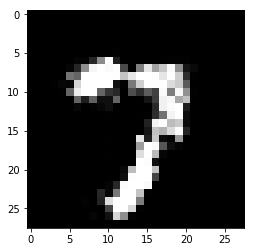

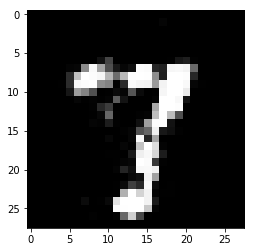

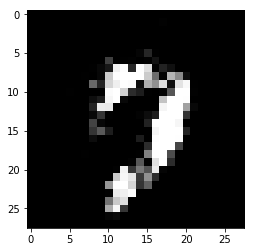

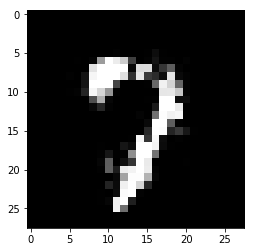

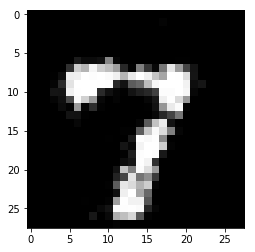

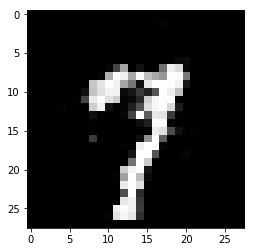

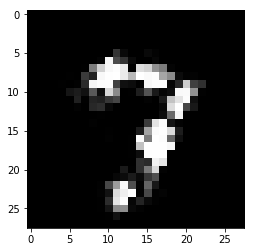

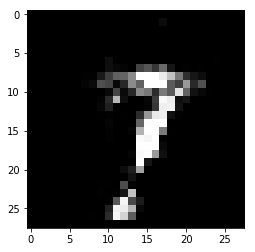

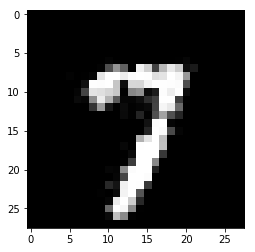

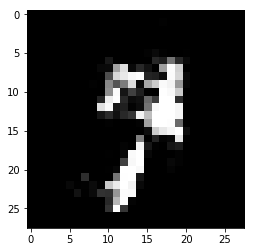

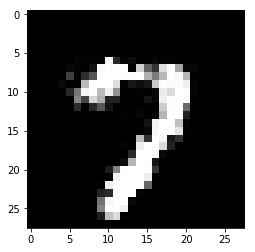

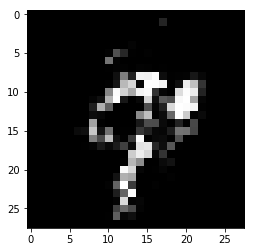

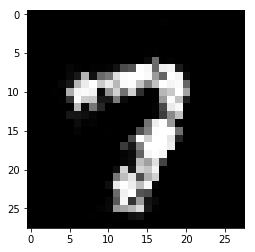

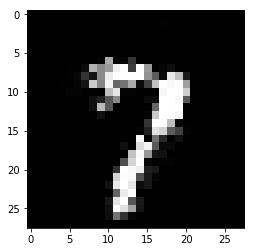

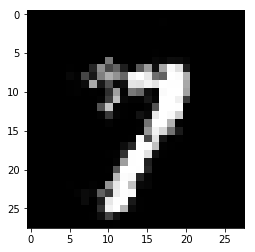

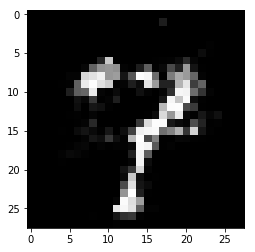

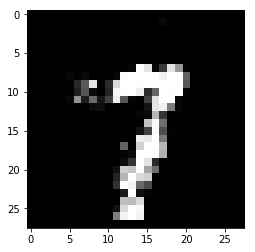

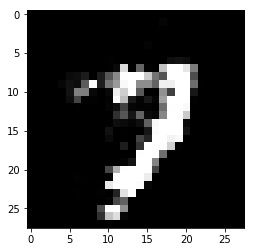

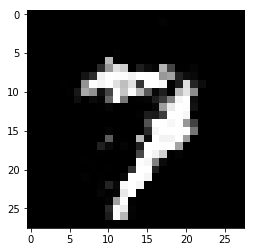

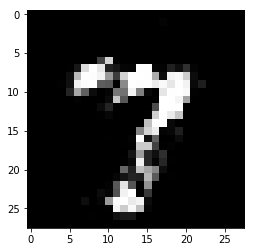

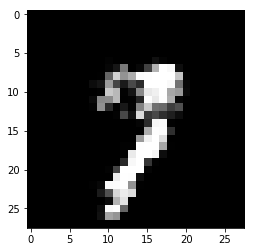

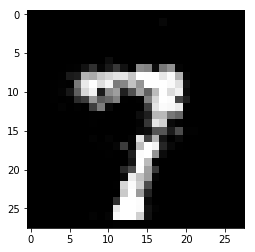

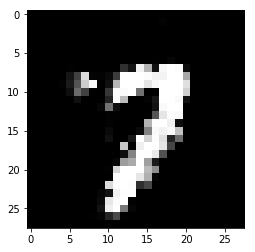

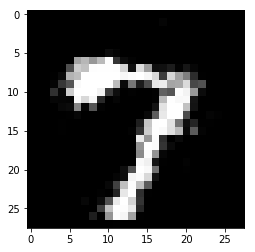

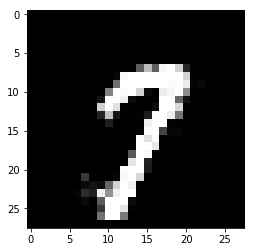

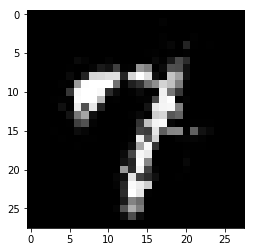

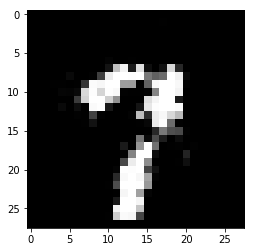

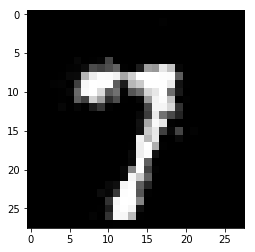

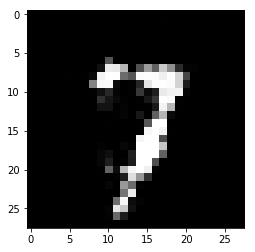

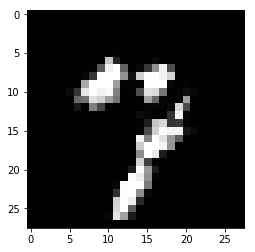

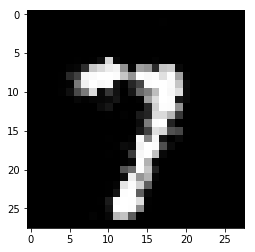

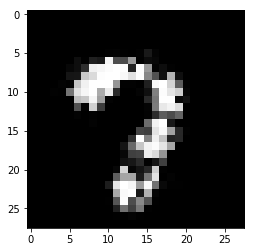

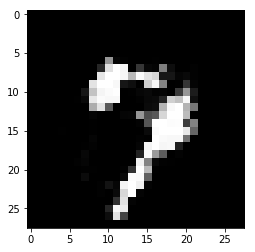

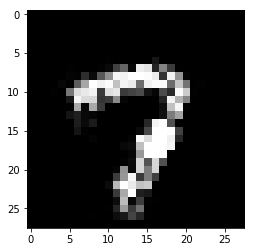

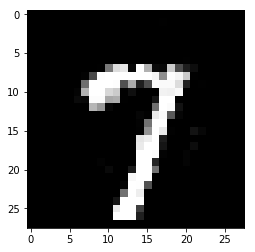

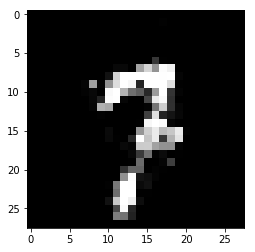

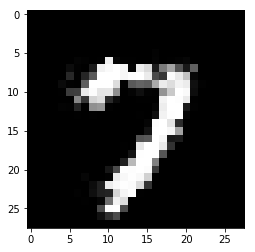

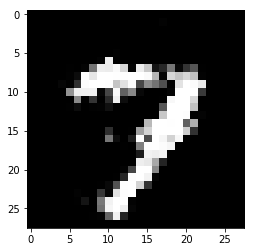

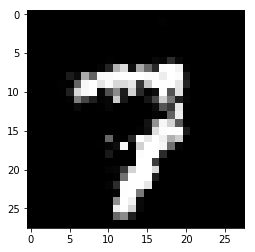

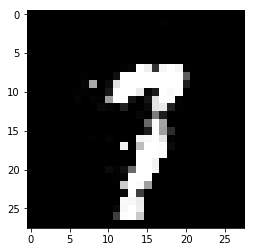

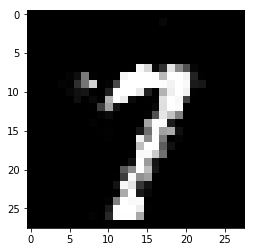

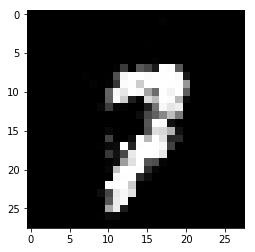

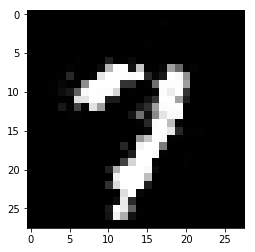

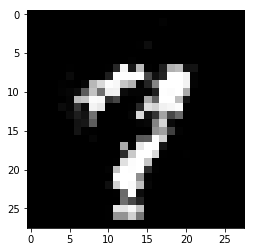

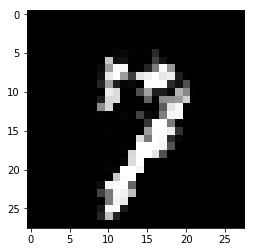

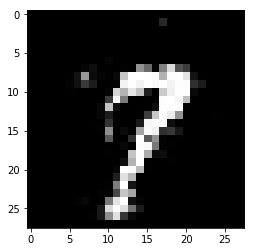

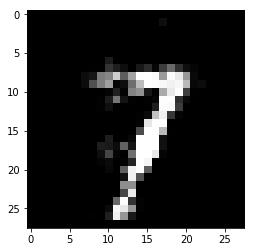

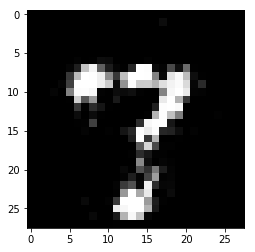

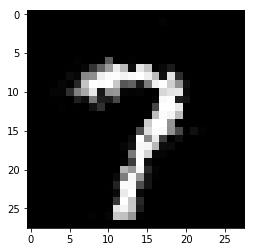

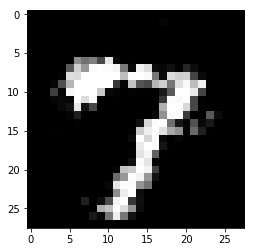

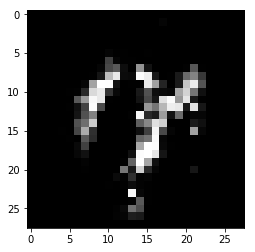

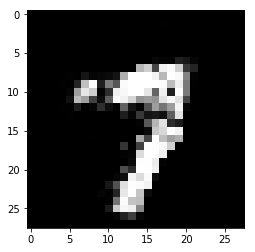

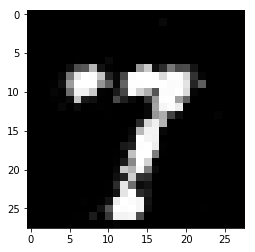

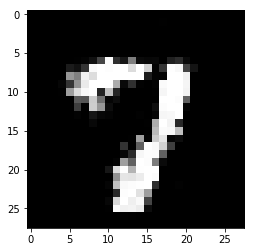

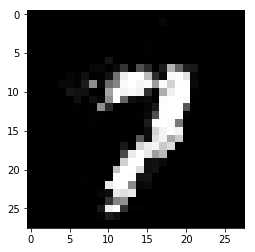

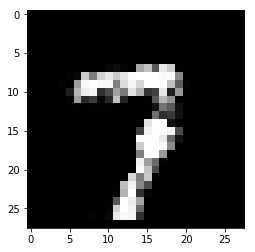

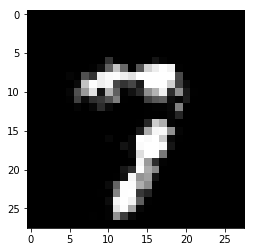

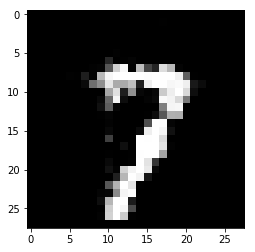

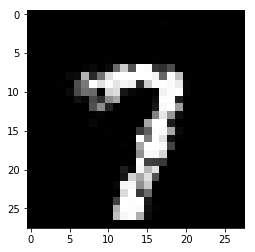

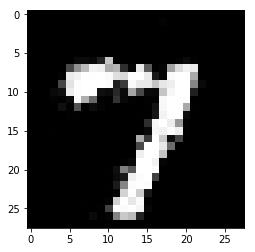

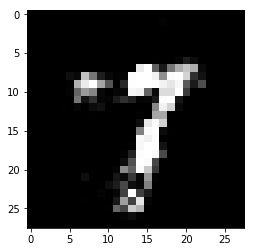

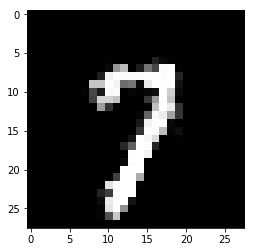

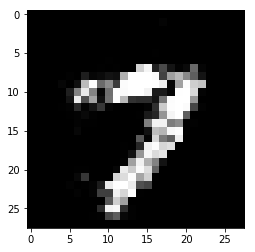

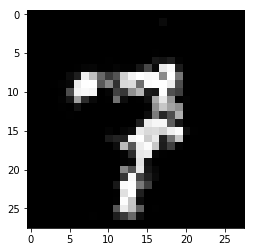

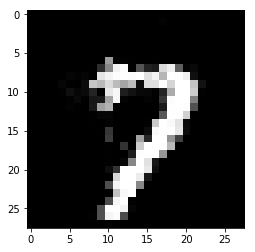

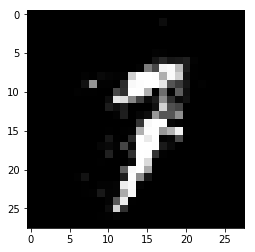

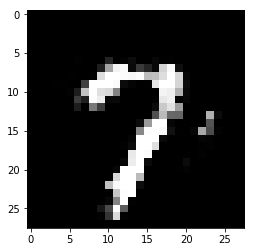

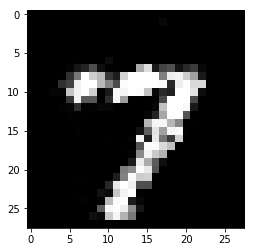

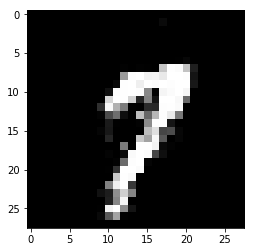

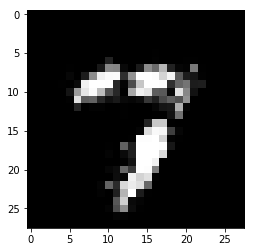

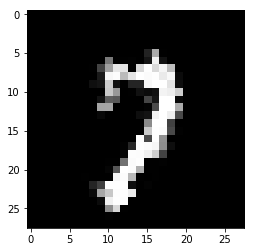

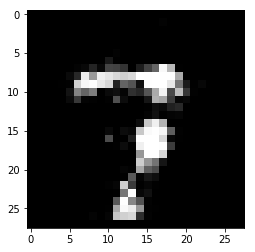

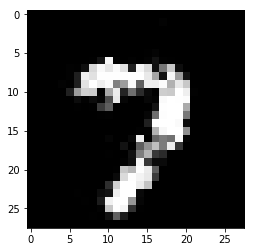

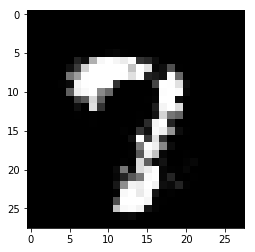

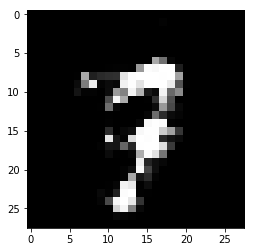

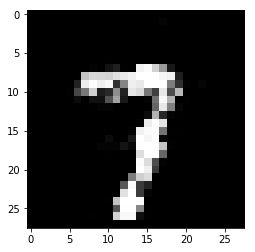

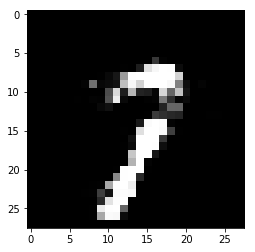

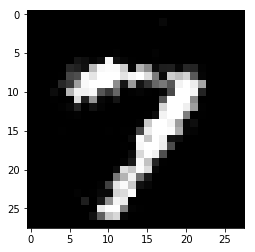

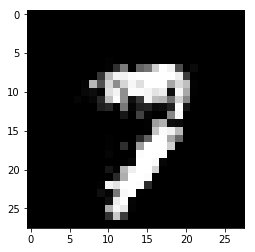

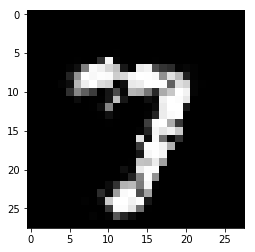

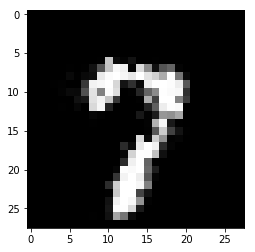

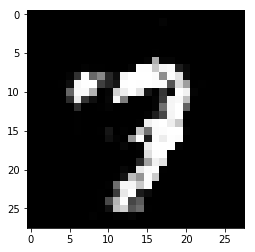

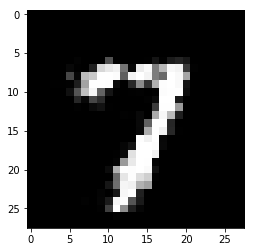

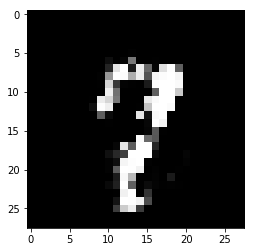

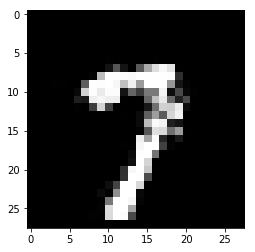

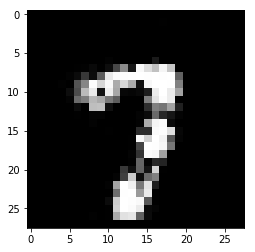

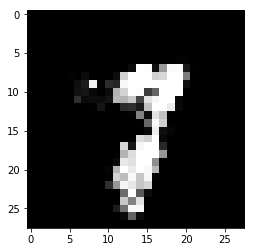

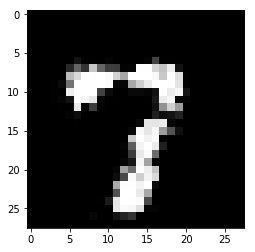

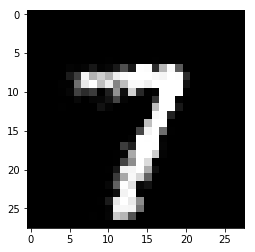

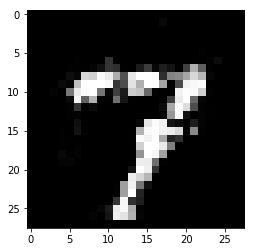

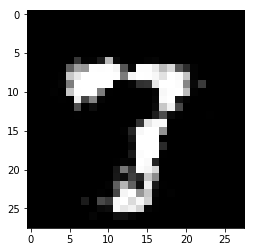

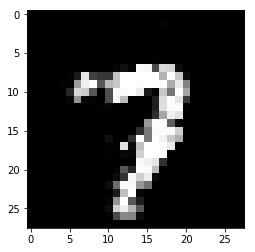

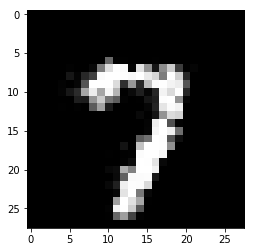

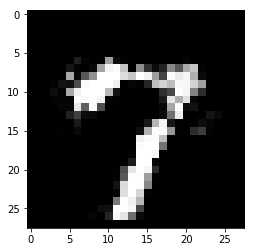

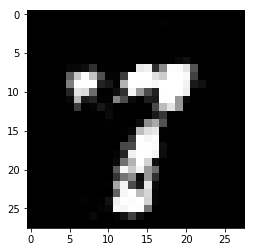

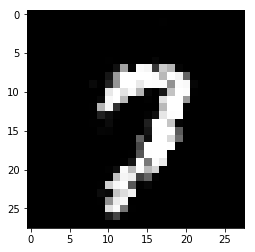

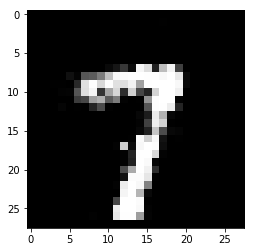

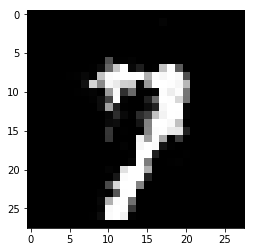

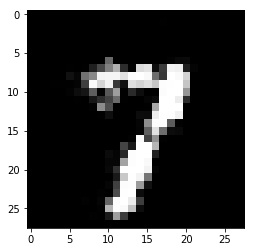

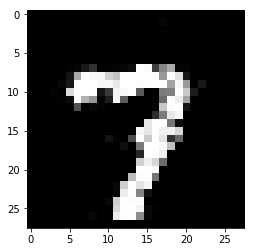

In [114]:
for s in X_sample:
    plt.imshow(np.reshape(s,(28,28)),cmap='gray')
    plt.show()